In [ ]:
%matplotlib inline

In [ ]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from PIL import Image
import cv2
import matplotlib.pylab as plt
import os
from matplotlib import pyplot as plt
import shutil, sys  
from sklearn.metrics import confusion_matrix
import itertools
from mlxtend.plotting import plot_confusion_matrix
import sklearn as skplt
!pip install scikit-plot  
import scikitplot as skplt
from skimage.exposure import rescale_intensity
from skimage.segmentation import slic
from skimage.util import img_as_float
from skimage import io


plt.ion()   # interactive mode

Se monta una cuenta de gmail, no es necesario si esta en un equipo local

In [ ]:
  %cd ..
from google.colab import drive
drive.mount('/content/gdrive')
!ln -s /content/gdrive/My\ Drive/ /mydrive
!ln -s /content/gdrive/Shared\ drives/Proyecto\ integrador\ de\ tecnologias\ emergentes/dataSets/ /mydata

/
Mounted at /content/gdrive


Creamos Carpeta data1 y all y dentro de data creamos las carpetas test y train, primero le llamamos data1 porque un zip se llama data, de esta manera no sobre escribimos la carpeta, si se tiene el data set ya intalado, no es necesario llamarla data1  

In [ ]:
%cd /content
import os
os.mkdir('data1')
os.mkdir('all')

%cd data1
os.mkdir('train')
os.mkdir('test')

/content
/content/data1


Copiamos el zip con una parte del dataset

In [ ]:
!cp /content/gdrive/Shared\ drives/Proyecto\ integrador\ de\ tecnologias\ emergentes/dataSets/data.zip  -d /content
#!cp /mydrive/SSD/train.zip -d /content

Descromprimimos el zip y sale la carpeta data.

In [ ]:
%cd /content
!unzip data.zip 
#!unzip train.zip 

Esta funcion normaliza los datos para el data loader

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

Como dije anteriormente la carpeta se llama data1 para no sobre escribirla, aqui renombramos las carpeta, data sera test, data1 sera data

In [ ]:

source = '/content/data'
dest = '/content/test'
os.rename(source, dest) 
source = '/content/data1'
dest = '/content/data'
os.rename(source, dest) 

Extraigo las clases del archivo de classes.txt

In [ ]:
class_names=[]
class2=open('/content/gdrive/Shared drives/Proyecto integrador de tecnologias emergentes/dataSets/classes.txt','r')
class2=class2.readlines()
class2 = [x.strip() for x in class2] 
for x in class2:
  x=x.replace(" ","")
  x=x.replace("/","-")
  class_names.append(x)


CHAPAPERILV


Se crea un directorio por cada clase dentro del archivo txt en las carpetas train, test y all

In [ ]:
for x in class_names:
  x=x.replace(" ","")
  x=x.replace("/","-")
  path1=os.path.join('/content/data/train', x)
  path2=os.path.join('/content/data/test', x)
  path3=os.path.join('/content/all', x)
  try:
    os.mkdir(path1)
    os.mkdir(path2)
    os.mkdir(path3)
  except OSError as error:
    print(x)


Eliminamos el zip de data para hacer espacio

In [ ]:
!rm /content/data.zip
#!rm /content/data2.zip

Normalizamos los archivos txt en los dataset, si uno tiene terminacion .xml.txt se convertira a txt solamente 

In [ ]:
path_train='/content/gdrive/Shared drives/Proyecto integrador de tecnologias emergentes/dataSets/data3'
for filename in os.listdir(path_train):
  infilename = os.path.join(path_train,filename)
  #print(infilename)
  if not os.path.isfile(infilename): continue
  oldbase = os.path.splitext(filename)
  newname = infilename.replace('.xml.txt', '.txt')
  output = os.rename(infilename, newname)

path_train='/content/test'
for filename in os.listdir(path_train):
  infilename = os.path.join(path_train,filename)
  if not os.path.isfile(infilename): continue
  oldbase = os.path.splitext(filename)
  newname = infilename.replace('.xml.txt', '.txt')
  output = os.rename(infilename, newname)

Esta funcio saca el ancho y largo de una imagen cuando le das el path

In [ ]:
def getimage (path):
  import cv2
  img = cv2.imread(path)
  h,w,c=img.shape
  return w,h

Esta funcion te regresa las bounding boxes de una imagen en formato yolo junto con la clase a la que pertenece

In [ ]:
def new_img(path,path2):
  #print(path)
  w,h=getimage(path)
  %matplotlib inline
  from matplotlib import pyplot as plt
  import cv2
  bounding_box_info=[]
  classes=[]
  xabs=[]
  yabs=[]
  habs=[]
  wabs=[]

  bounding_box=open(path2,'r')
  bounding_box=bounding_box.readlines()
  bounding_box = [x.strip() for x in bounding_box] 
  for x in bounding_box:
   x=x.split(' ')
   x=list(map(float,x))
   bounding_box_info.append(x)
  for x in range(len(bounding_box_info)):
     if bounding_box_info[x][0] > 44:
       bounding_box_info[x][0]=0
     classes.append(bounding_box_info[x][0])
     xabs.append(bounding_box_info[x][1]*w)
     yabs.append(bounding_box_info[x][2]*h)
     wabs.append(bounding_box_info[x][3]*w)
     habs.append(bounding_box_info[x][4]*h)

  return xabs,yabs,wabs,habs,classes
       

Esta funcion hace el recorte con los valores de las bounding boxes que dio la funcion anterior, y las manda (el recorte) a la carpeta con la etiqueta correspondiente

In [ ]:
def moveimg(path_from_jpg,path_move,class_names):
  %matplotlib inline
  from matplotlib import pyplot as plt
  import cv2
  from pathlib import Path    
  path_from_txt=path_from_jpg.replace('.JPG','.txt')
  #print(path_from_txt)
  xabs,yabs,wabs,habs,classes=new_img(path_from_jpg,path_from_txt)
  img=cv2.imread(path_from_jpg)
  for x in range(len(xabs)):
      x1=round(xabs[x]-(wabs[x]/2))
      y1=round(yabs[x]-(habs[x]/2))
      x2=round(xabs[x]+(wabs[x]/2))
      y2=round(yabs[x]+(habs[x]/2))
      img2=img[y1:y2,x1:x2]
      c=class_names[int(classes[x])]
      new_path=os.path.join(path_move,c)
      name=Path(path_from_jpg).name
      y=random.randint(0,1000)
      name=str(x)+str(y)+name
      new_path=os.path.join(new_path,name)
      cv2.imwrite(new_path,img2)


Para evitar que crashe el codigo, esta funcion comprueba que el archivo jpg contenga su reciproco en txt. 

In [ ]:
def checkFileExistance(filePath):
    try:
        with open(filePath, 'r') as f:
            return True
    except FileNotFoundError as e:
        return False
    except IOError as e:
        return False

Las funciones anteriores entran en accion, nos metemos al la carpeta 3 que es donde se encuentran las etiquetas con su respectivas anotaciones e imagenes, iteramos entre todas y se hacen los recortes correspondientes, si se cumplen las funciones como que el archivo exista, ademas se crea la direccion correspondiente al archivo txt, el archivo txt debe tener el mismo nombre de la imagen

In [ ]:
path_move='/content/all'
path_from='/content/gdrive/Shared drives/Proyecto integrador de tecnologias emergentes/dataSets/data3'
for filename in os.listdir(path_from):
  path_from_jpg=os.path.join(path_from, str (filename))
  path_from_txt1=path_from_jpg.replace('.JPG','.txt')
  txt_exist=checkFileExistance(path_from_txt1)
  if txt_exist and filename.endswith(".JPG") or filename.endswith(".jpg") :
    moveimg(path_from_jpg,path_move,class_names)

path_move2='/content/all'
path_from='/content/test'
for filename in os.listdir(path_from):
  path_from_jpg=os.path.join(path_from, str (filename))
  path_from_txt1=path_from_jpg.replace('.JPG','.txt')
  txt_exist=checkFileExistance(path_from_txt1)
  if txt_exist and filename.endswith(".JPG") or filename.endswith(".jpg"):
    moveimg(path_from_jpg,path_move2,class_names)

De la carpeta all, eliminamos todas las carpetas que no tengan imagenes adentro

In [ ]:
path_move='/content/all'

root = path_move
folders = list(os.walk(root))[1:]

for folder in folders:
    # folder example: ('FOLDER/3', [], ['file'])
    if not folder[2]:
        os.rmdir(folder[0])

Funcion para realizar data augmentation, se le da un resize ala imagen que pase por aqui, si vuelve a pasar se le da vueltas si vuelve a pasar cambia la iluminacion si vuelve a pasar se le cambia el color y si vuelve a pasar se aplica un blur

In [ ]:
def data_aug(path,filename,x):
  path_read=os.path.join(path, str (filename))
  #print(path_read)
  image=cv2.imread(path_read)
  w=random.randint(50,250)
  h=random.randint(50,250)
  if x==0:
    #Resize
    image=cv2.resize(image,(w,h))
    name='r_'+str(filename)
    path_save=os.path.join(path, str (name))
    cv2.imwrite(path_save,image)
  if x==1:
    #flip
    image=cv2.flip(image, 2)
    name='f_'+str(filename)
    path_save=os.path.join(path, str (name))
    cv2.imwrite(path_save,image)
  if x==2:
    #light
    invGamma = 1.0 / 2
    table = np.array([((i / 255.0) ** invGamma) * 255
                      for i in np.arange(0, 256)]).astype("uint8")
    image2=cv2.LUT(image, table)
    name='l_'+str(filename)
    path_save=os.path.join(path, str (name))
    cv2.imwrite(path_save,image2)
  if x==3:
    #Change color
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    name='bgr_'+str(filename)
    path_save=os.path.join(path, str (name))
    cv2.imwrite(path_save,image)
  if x==4:
    #BLUR
    kernel = np.ones((5,5),np.float32)/40
    image = cv2.filter2D(image,-1,kernel)
    name='blur_'+str(filename)
    path_save=os.path.join(path, str (name))
    cv2.imwrite(path_save,image)

Pasamos el 80% de las imagenes de la carpeta all a train y el 20% a test siempre y cuando haya un minimo de 500 imagenes . La variable test batch mide esto
100/.2 = 500 por lo tanto test_batch debe de ser mayor a 100.


500= 100% ----> ?=20%

In [ ]:
import shutil, sys  
path_move='/content/all'
for dir in os.listdir(path_move):
  x=0
  #print(dir)
  new_path=os.path.join(path_move, str (dir))
  #print(new_path)
  if dir.endswith('.JPG'):
    os.remove(new_path)
  else:
    for files in os.listdir(new_path):
      number= sum(1 for files in os.listdir(new_path))
      #print(number)
      test_batch=round(number*.2)
      if test_batch>100:
        new_path2=os.path.join(new_path, str (files))
        goto_path=os.path.join('/content/data/test',str(dir))
        goto_path=os.path.join(goto_path,str(files))
        if x<= test_batch:
          shutil.copy2(str(new_path2),str(goto_path))
          x=x+1
        else:
          goto_path=os.path.join('/content/data/train',str(dir))
          goto_path=os.path.join(goto_path,str(files))
          shutil.copy2(str(new_path2),str(goto_path))

In [ ]:
path_move='/content/data/train'
path_move2='/content/data/test'

root = path_move
folders = list(os.walk(root))[1:]

for folder in folders:
    # folder example: ('FOLDER/3', [], ['file'])
    if not folder[2]:
        os.rmdir(folder[0])

root = path_move2
folders = list(os.walk(root))[1:]

for folder in folders:
    # folder example: ('FOLDER/3', [], ['file'])
    if not folder[2]:
        os.rmdir(folder[0])

DATA AUGMENTATION

Esta primera funcion nos muestra la distribucion en cuanto a la cantidad de datos

In [ ]:
path_check='/content/data/train'
val1=0
for files in os.listdir(path_check):
  new_path=os.path.join(path_check, str (files))
  print(files)
  val2=len(os.listdir(new_path))
  print(val2)
  if val1<val2:
    val1=val2
    dir=files
print(val1)

print("Test")
path_check='/content/data/test'
val1_1=0
for files in os.listdir(path_check):
  new_path=os.path.join(path_check, str (files))
  print(files)
  val2_2=len(os.listdir(new_path))
  print(val2_2)
  if val1_1<val2_2:
    val1_1=val2_2
    dir2=files
print(val1_1)

MADERA
979
OXIDO
625
CHAPASUELTA-LAMINASUELTA
465
CABLES
1574
CUERDA
1308
TUBO
403
AGLOMERACIÓNBASURA
501
1574
Test
MADERA
246
OXIDO
158
CHAPASUELTA-LAMINASUELTA
118
CABLES
395
CUERDA
328
TUBO
102
AGLOMERACIÓNBASURA
127
395


Aqui comamos la carpeta con mas datos y tomamos su cantidad como referencia, posteriormente iremos iterando entre cada imagen aplicando data augmentation hasta que el numero llegue a la misma cantidad de datos que la carpeta de referencia. Se aplica para test y train

In [ ]:
path_check='/content/data/train'
for files in os.listdir(path_check):
  new_path=os.path.join(path_check, str (files))
  x=0
  for images in os.listdir(new_path):
    while x<6:
      data_aug(new_path,images,x)
      x=x+1
    amount=len(os.listdir(new_path))
    x=0
    if amount>=val1:
      break

path_check='/content/data/test'
for files in os.listdir(path_check):
  new_path=os.path.join(path_check, str (files))
  x=0
  for images in os.listdir(new_path):
    while x<6:
      data_aug(new_path,images,x)
      x=x+1
    x=0
    amount=len(os.listdir(new_path))
    if amount>=val1_1:
      break

Volvemos a checar la distribucion de datos post-data augmentation

In [ ]:
path_check='/content/data/train'
val1=0
for files in os.listdir(path_check):
  new_path=os.path.join(path_check, str (files))
  print(files)
  val2=len(os.listdir(new_path))
  print(val2)
  if val1<val2:
    val1=val2
    dir=files

print("Test")
path_check='/content/data/test'
val1_1=0
for files in os.listdir(path_check):
  new_path=os.path.join(path_check, str (files))
  print(files)
  val2_2=len(os.listdir(new_path))
  print(val2_2)
  if val1_1<val2_2:
    val1_1=val2_2
    dir2=files


MADERA
1574
OXIDO
1575
CHAPASUELTA-LAMINASUELTA
1575
CABLES
1579
CUERDA
1578
TUBO
1578
AGLOMERACIÓNBASURA
1576
Test
MADERA
396
OXIDO
398
CHAPASUELTA-LAMINASUELTA
398
CABLES
400
CUERDA
398
TUBO
397
AGLOMERACIÓNBASURA
397


Se cargan los datos a los data-loaders para aplicar entrenamiento. Ademas se crean la nueva cantidad de clases y se ponen en un archivo txt

In [ ]:
data_dir = '/content/data'
classes=''
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in  ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in  ['train', 'test']}
class_names = image_datasets['train'].classes
for i in class_names:
  classes=classes + '\n'+i
f= open("/mydrive/SSD/class_names2.txt","w")
f=f.write(classes)
print(class_names)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

['AGLOMERACIÓNBASURA', 'CABLES', 'CHAPASUELTA-LAMINASUELTA', 'CUERDA', 'MADERA', 'OXIDO', 'TUBO']


In [ ]:
print(dataset_sizes)

{'train': 11035, 'test': 2784}


Funcion para visualizar imagenes de los data loaders y sus etiquetas

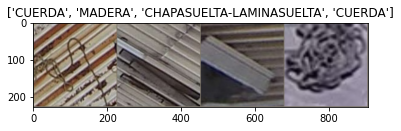

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Funcion ara entrenar el modelo

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())


    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Finetuning

Cargamos un modelo preentrenado y reseteamos las ultimas capas que haces las inferencias.


In [ ]:
model_ft = models.resnet101(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth


Entrenamos por primera ver el modelo y guardamos el resultado

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=25)
torch.save(model_ft,'/mydrive/SSD/model_resnet_train.pth')

Epoch 0/24
----------
train Loss: 1.4748 Acc: 0.4765
test Loss: 1.0795 Acc: 0.6545
Epoch 1/24
----------
train Loss: 1.0333 Acc: 0.6343
test Loss: 0.7881 Acc: 0.7478
Epoch 2/24
----------
train Loss: 0.8540 Acc: 0.6980
test Loss: 0.7689 Acc: 0.7687
Epoch 3/24
----------
train Loss: 0.7511 Acc: 0.7358
test Loss: 0.8374 Acc: 0.7676
Epoch 4/24
----------
train Loss: 0.7048 Acc: 0.7525
test Loss: 0.6435 Acc: 0.8006
Epoch 5/24
----------
train Loss: 0.6150 Acc: 0.7818
test Loss: 0.8944 Acc: 0.7694
Epoch 6/24
----------
train Loss: 0.5775 Acc: 0.8005
test Loss: 0.8694 Acc: 0.8139
Epoch 7/24
----------
train Loss: 0.4378 Acc: 0.8478
test Loss: 0.5298 Acc: 0.8567
Epoch 8/24
----------
train Loss: 0.3829 Acc: 0.8681
test Loss: 0.5376 Acc: 0.8635
Epoch 9/24
----------
train Loss: 0.3731 Acc: 0.8753
test Loss: 0.5795 Acc: 0.8524
Epoch 10/24
----------
train Loss: 0.3527 Acc: 0.8807
test Loss: 0.4720 Acc: 0.8664
Epoch 11/24
----------
train Loss: 0.3392 Acc: 0.8835
test Loss: 0.5549 Acc: 0.8628
Ep

Funcion para visualizar los resultados

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

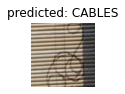

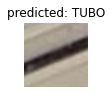

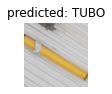

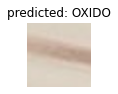

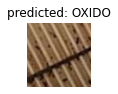

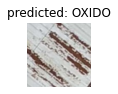

In [ ]:
visualize_model(model_ft)

ConvNet as fixed feature extractor
----------------------------------

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad == False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.






In [ ]:
model_conv = model_ft.to(device)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, len(class_names))

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)
torch.save(model_conv,'/mydrive/SSD/model_resnet.pth')

Epoch 0/24
----------
train Loss: 0.4351 Acc: 0.8745
test Loss: 0.4630 Acc: 0.8750
Epoch 1/24
----------
train Loss: 0.3165 Acc: 0.8942
test Loss: 0.5203 Acc: 0.8682
Epoch 2/24
----------
train Loss: 0.3170 Acc: 0.8936
test Loss: 0.5853 Acc: 0.8639
Epoch 3/24
----------
train Loss: 0.3075 Acc: 0.8932
test Loss: 0.5373 Acc: 0.8743
Epoch 4/24
----------
train Loss: 0.3033 Acc: 0.8957
test Loss: 0.5612 Acc: 0.8732
Epoch 5/24
----------
train Loss: 0.2997 Acc: 0.9020
test Loss: 0.5543 Acc: 0.8725
Epoch 6/24
----------
train Loss: 0.3035 Acc: 0.8954
test Loss: 0.5748 Acc: 0.8714
Epoch 7/24
----------
train Loss: 0.2930 Acc: 0.8985
test Loss: 0.6494 Acc: 0.8707
Epoch 8/24
----------
train Loss: 0.2931 Acc: 0.9035
test Loss: 0.5855 Acc: 0.8675
Epoch 9/24
----------
train Loss: 0.3006 Acc: 0.8975
test Loss: 0.6177 Acc: 0.8664
Epoch 10/24
----------
train Loss: 0.2962 Acc: 0.8988
test Loss: 0.5386 Acc: 0.8743
Epoch 11/24
----------
train Loss: 0.2990 Acc: 0.8984
test Loss: 0.6279 Acc: 0.8667
Ep

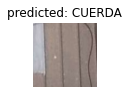

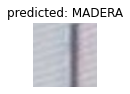

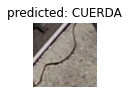

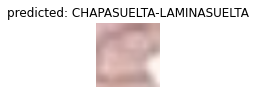

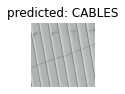

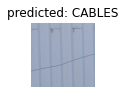

In [ ]:
visualize_model(model_conv)
plt.ioff()
plt.show()

Creamos funcion  que procesa la imagen para que el modelo pueda hacer deteccion

In [ ]:
def image_loader2(image):
    from PIL import Image
    import cv2
    imsize = 256
    loader = transforms.Compose([transforms.Resize(imsize), transforms.ToTensor()])
    image = loader(image).float()
    #image = Variable(image, requires_grad=True)
    image = image.unsqueeze(0)  #this is for VGG, may not be needed for ResNet
    return image.cuda()  #assumes that you're using GPU

Funcion que recibe el modelo, la imagen y las clases y saca el indice con respecto al archivo classes de la prediccion y la confianza

In [ ]:
def detect(net,image,class_names):
  image = image_loader2(image)
  net.eval()
  output = net(image)
  _, predicted = torch.max(output, 1)
  confidence=torch.nn.functional.softmax(output, dim=1)[0]
  confidence=confidence[predicted[0]].item()*100
  classification1 = predicted.data
  index = int(classification1)
  #names = net.classes
  return confidence,class_names[index]

Funcion que crea la matriz de confusion

In [ ]:
def matrix_conf(net,class_names):
  path='/content/data/test'
  real=[]
  predicted=[]
  for class1 in os.listdir(path):
    new_path=os.path.join(path, str (class1))
    for class2 in os.listdir(new_path):
      real.extend([str(class1)])  
      check=os.path.join(new_path, str (class2))
      check=str(check)
      image = cv2.imread(check)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      image=Image.fromarray(image)
      _,name=detect(net,image,class_names)
      predicted.extend([name])
      y_pred=predicted
      y_true=real
  confusion=confusion_matrix(real,predicted)
  return confusion,real,predicted

In [ ]:
matrix_resnet,real_resnet,predicted_resnet(model_conv,class_names)

Funcion que lograr crear la visualizacion de la matriz de confusion

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)
    plt.figure(figsize=(len(classes), len(classes)))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '1f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization


<Figure size 432x288 with 0 Axes>

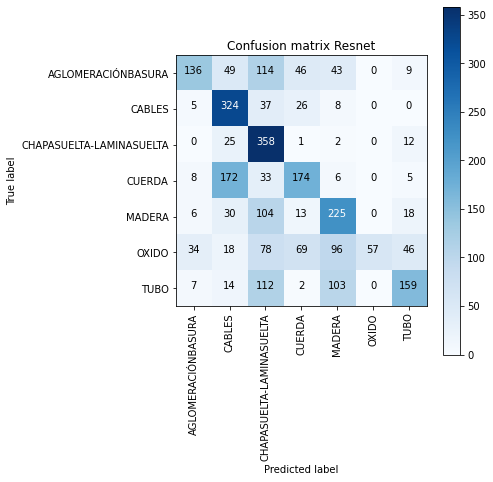

In [ ]:
plt.figure()
plot_confusion_matrix(matrix_resnet, classes=class_names,
                      title='Confusion matrix Resnet')
plt.show()

Funcion para congelar todas las capas menos la ultima 

In [ ]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

VGG  19 TRAIN


In [ ]:
model_ft_vgg = models.vgg19_bn(pretrained=True)
set_parameter_requires_grad(model_ft_vgg, True)
num_ftrs = model_ft_vgg.classifier[6].in_features
model_ft_vgg.classifier[6] = nn.Linear(num_ftrs, len(class_names))
input_size = 224

model_ft_vgg = model_ft_vgg.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft_vgg.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth


In [ ]:
model_ft_vgg=train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=25)
torch.save(model_ft_vgg,'/mydrive/SSD/model_vgg19_train.pth')

Epoch 0/24
----------
train Loss: 0.2927 Acc: 0.9028
test Loss: 0.4909 Acc: 0.8750
Epoch 1/24
----------
train Loss: 0.2857 Acc: 0.9019
test Loss: 0.5932 Acc: 0.8667
Epoch 2/24
----------
train Loss: 0.2954 Acc: 0.9021
test Loss: 0.5173 Acc: 0.8757
Epoch 3/24
----------
train Loss: 0.2894 Acc: 0.9010
test Loss: 0.5033 Acc: 0.8754
Epoch 4/24
----------
train Loss: 0.2807 Acc: 0.9034
test Loss: 0.5644 Acc: 0.8757
Epoch 5/24
----------
train Loss: 0.2942 Acc: 0.8985
test Loss: 0.6357 Acc: 0.8614
Epoch 6/24
----------
train Loss: 0.2918 Acc: 0.8994
test Loss: 0.5814 Acc: 0.8693
Epoch 7/24
----------
train Loss: 0.2933 Acc: 0.8997
test Loss: 0.5673 Acc: 0.8739
Epoch 8/24
----------
train Loss: 0.2873 Acc: 0.9029
test Loss: 0.6122 Acc: 0.8675
Epoch 9/24
----------
train Loss: 0.2947 Acc: 0.9000
test Loss: 0.5115 Acc: 0.8750
Epoch 10/24
----------
train Loss: 0.2823 Acc: 0.9036
test Loss: 0.5672 Acc: 0.8739
Epoch 11/24
----------
train Loss: 0.2909 Acc: 0.9019
test Loss: 0.7053 Acc: 0.8614
Ep

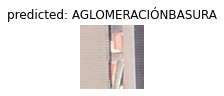

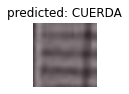

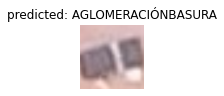

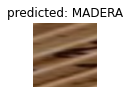

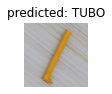

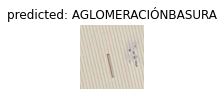

In [ ]:
visualize_model(model_ft_vgg)

In [ ]:
model_ft_vgg = model_ft_vgg.to(device)
params_to_update = model_ft_vgg.parameters()
if True:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

In [ ]:
model_vgg = train_model(model_ft_vgg, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=25)
torch.save(model_vgg,'/mydrive/SSD/model_vgg19.pth')

Epoch 0/24
----------
train Loss: 0.2987 Acc: 0.8943
test Loss: 0.5361 Acc: 0.8710
Epoch 1/24
----------
train Loss: 0.3013 Acc: 0.8966
test Loss: 0.6710 Acc: 0.8649
Epoch 2/24
----------
train Loss: 0.3111 Acc: 0.8922
test Loss: 0.6304 Acc: 0.8700
Epoch 3/24
----------
train Loss: 0.3041 Acc: 0.8958
test Loss: 0.6599 Acc: 0.8624
Epoch 4/24
----------
train Loss: 0.2899 Acc: 0.8977
test Loss: 0.5827 Acc: 0.8682
Epoch 5/24
----------
train Loss: 0.2930 Acc: 0.8986
test Loss: 0.6293 Acc: 0.8675
Epoch 6/24
----------
train Loss: 0.3092 Acc: 0.8942
test Loss: 0.6333 Acc: 0.8653
Epoch 7/24
----------
train Loss: 0.2979 Acc: 0.9015
test Loss: 0.6293 Acc: 0.8596
Epoch 8/24
----------
train Loss: 0.2998 Acc: 0.8978
test Loss: 0.7190 Acc: 0.8570
Epoch 9/24
----------
train Loss: 0.2854 Acc: 0.9035
test Loss: 0.6577 Acc: 0.8639
Epoch 10/24
----------
train Loss: 0.2952 Acc: 0.9002
test Loss: 0.6881 Acc: 0.8671
Epoch 11/24
----------
train Loss: 0.2911 Acc: 0.9000
test Loss: 0.5617 Acc: 0.8757
Ep

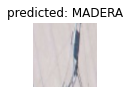

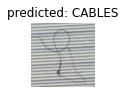

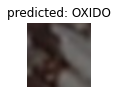

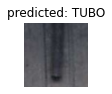

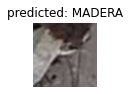

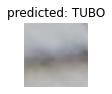

In [ ]:
visualize_model(model_vgg)

In [ ]:
matrix_vgg,real_vgg,predicted_vgg=matrix_conf(model_vgg,class_names)

Confusion matrix, without normalization


<Figure size 432x288 with 0 Axes>

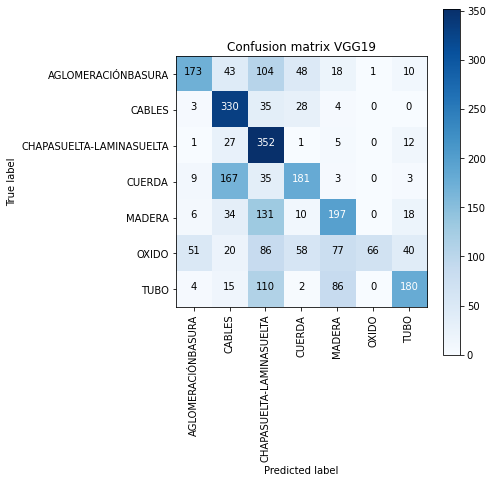

In [ ]:
plt.figure()
plot_confusion_matrix(matrix_vgg, classes=class_names,
                      title='Confusion matrix VGG19')
plt.show()

GOOGLENET TRAIN

In [ ]:
model_ft_googlenet = models.googlenet(pretrained=True)
num_ftrs = model_ft_googlenet.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft_googlenet.fc = nn.Linear(num_ftrs, len(class_names))

model_ft_googlenet = model_ft_googlenet.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft_googlenet.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


In [ ]:
model_googlenet = train_model(model_ft_googlenet, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=25)
torch.save(model_googlenet,'/mydrive/SSD/model_googlenet_train.pth')

Epoch 0/24
----------
train Loss: 1.3859 Acc: 0.4843
test Loss: 0.9537 Acc: 0.6659
Epoch 1/24
----------
train Loss: 1.1294 Acc: 0.5999
test Loss: 0.8126 Acc: 0.7270
Epoch 2/24
----------
train Loss: 0.9935 Acc: 0.6529
test Loss: 0.7422 Acc: 0.7507
Epoch 3/24
----------
train Loss: 0.8846 Acc: 0.6887
test Loss: 0.7693 Acc: 0.7561
Epoch 4/24
----------
train Loss: 0.8256 Acc: 0.7111
test Loss: 0.6862 Acc: 0.7766
Epoch 5/24
----------
train Loss: 0.7654 Acc: 0.7332
test Loss: 0.7694 Acc: 0.7611
Epoch 6/24
----------
train Loss: 0.7301 Acc: 0.7492
test Loss: 0.6026 Acc: 0.8096
Epoch 7/24
----------
train Loss: 0.6011 Acc: 0.7940
test Loss: 0.4635 Acc: 0.8470
Epoch 8/24
----------
train Loss: 0.5600 Acc: 0.8071
test Loss: 0.4661 Acc: 0.8499
Epoch 9/24
----------
train Loss: 0.5318 Acc: 0.8179
test Loss: 0.4211 Acc: 0.8592
Epoch 10/24
----------
train Loss: 0.5219 Acc: 0.8199
test Loss: 0.4545 Acc: 0.8531
Epoch 11/24
----------
train Loss: 0.5002 Acc: 0.8295
test Loss: 0.4399 Acc: 0.8556
Ep

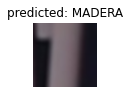

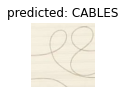

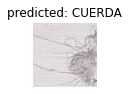

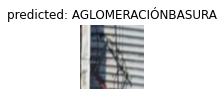

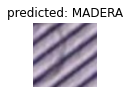

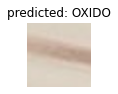

In [ ]:
visualize_model(model_googlenet)

In [ ]:
model_conv = model_googlenet.to(device)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, len(class_names))

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [ ]:
model_googlenet = train_model(model_conv, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=25)
torch.save(model_googlenet,'/mydrive/SSD/model_googlenet.pth')

Epoch 0/24
----------
train Loss: 1.9697 Acc: 0.1190


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


test Loss: 1.9966 Acc: 0.0769
Epoch 1/24
----------
train Loss: 1.9699 Acc: 0.1141
test Loss: 1.9943 Acc: 0.0833
Epoch 2/24
----------
train Loss: 1.9713 Acc: 0.1170
test Loss: 2.0002 Acc: 0.0873
Epoch 3/24
----------
train Loss: 1.9707 Acc: 0.1146
test Loss: 1.9846 Acc: 0.0808
Epoch 4/24
----------
train Loss: 1.9713 Acc: 0.1124
test Loss: 1.9925 Acc: 0.0758
Epoch 5/24
----------
train Loss: 1.9722 Acc: 0.1124
test Loss: 1.9930 Acc: 0.0934
Epoch 6/24
----------
train Loss: 1.9698 Acc: 0.1122
test Loss: 1.9951 Acc: 0.0833
Epoch 7/24
----------
train Loss: 1.9710 Acc: 0.1123
test Loss: 1.9980 Acc: 0.0787
Epoch 8/24
----------
train Loss: 1.9701 Acc: 0.1155
test Loss: 1.9993 Acc: 0.0715
Epoch 9/24
----------
train Loss: 1.9695 Acc: 0.1156
test Loss: 2.0012 Acc: 0.0740
Epoch 10/24
----------
train Loss: 1.9693 Acc: 0.1159
test Loss: 2.0018 Acc: 0.0837
Epoch 11/24
----------
train Loss: 1.9695 Acc: 0.1167
test Loss: 1.9964 Acc: 0.0948
Epoch 12/24
----------
train Loss: 1.9693 Acc: 0.1118
t

In [ ]:
matrix_googlenet,real_googlenet,predicted_googlenet=matrix_conf(model_googlenet,class_names)

Confusion matrix, without normalization


<Figure size 432x288 with 0 Axes>

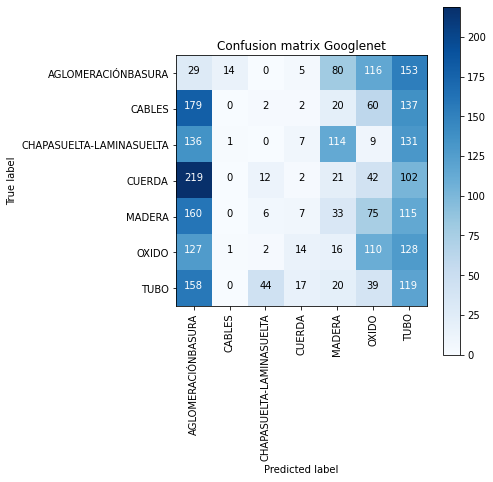

In [ ]:
plt.figure()
plot_confusion_matrix(matrix_googlenet, classes=class_names,
                      title='Confusion matrix Googlenet')
plt.show()

VGG 16 train

In [ ]:
model_ft_vgg = models.vgg16_bn(pretrained=True)
set_parameter_requires_grad(model_ft_vgg, True)
num_ftrs = model_ft_vgg.classifier[6].in_features
model_ft_vgg.classifier[6] = nn.Linear(num_ftrs, len(class_names))
input_size = 224

model_ft_vgg = model_ft_vgg.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft_vgg.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


In [ ]:
model_ft_vgg=train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=25)
torch.save(model_ft_vgg,'/mydrive/SSD/model_vgg11_train.pth')

Epoch 0/24
----------
train Loss: 0.2903 Acc: 0.8991
test Loss: 0.5762 Acc: 0.8707
Epoch 1/24
----------
train Loss: 0.2864 Acc: 0.9036
test Loss: 0.5753 Acc: 0.8707
Epoch 2/24
----------
train Loss: 0.2953 Acc: 0.9008
test Loss: 0.7445 Acc: 0.8549
Epoch 3/24
----------
train Loss: 0.2822 Acc: 0.9029
test Loss: 0.6534 Acc: 0.8635
Epoch 4/24
----------
train Loss: 0.3050 Acc: 0.8951
test Loss: 0.5651 Acc: 0.8610
Epoch 5/24
----------
train Loss: 0.2812 Acc: 0.9027
test Loss: 0.5407 Acc: 0.8746
Epoch 6/24
----------
train Loss: 0.2899 Acc: 0.8997
test Loss: 0.6155 Acc: 0.8675
Epoch 7/24
----------
train Loss: 0.2891 Acc: 0.9049
test Loss: 0.5888 Acc: 0.8642
Epoch 8/24
----------
train Loss: 0.2898 Acc: 0.9027
test Loss: 0.7329 Acc: 0.8610
Epoch 9/24
----------
train Loss: 0.2986 Acc: 0.8968
test Loss: 0.5925 Acc: 0.8746
Epoch 10/24
----------
train Loss: 0.2964 Acc: 0.9017
test Loss: 0.6126 Acc: 0.8682
Epoch 11/24
----------
train Loss: 0.2937 Acc: 0.9000
test Loss: 0.5658 Acc: 0.8772
Ep

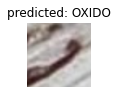

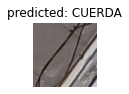

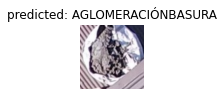

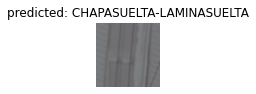

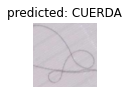

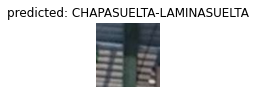

In [ ]:
visualize_model(model_ft_vgg)

In [ ]:
model_ft_vgg = model_ft_vgg.to(device)
params_to_update = model_ft_vgg.parameters()
if True:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

In [ ]:
model_vgg = train_model(model_ft_vgg, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=25)
torch.save(model_vgg,'/mydrive/SSD/model_vgg11.pth')

Epoch 0/24
----------
train Loss: 0.2986 Acc: 0.8993
test Loss: 0.7923 Acc: 0.8560
Epoch 1/24
----------
train Loss: 0.3020 Acc: 0.8960
test Loss: 0.6618 Acc: 0.8671
Epoch 2/24
----------
train Loss: 0.2896 Acc: 0.9005
test Loss: 0.5806 Acc: 0.8693
Epoch 3/24
----------
train Loss: 0.2778 Acc: 0.9048
test Loss: 0.6034 Acc: 0.8657
Epoch 4/24
----------
train Loss: 0.2848 Acc: 0.9046
test Loss: 0.6349 Acc: 0.8682
Epoch 5/24
----------
train Loss: 0.2977 Acc: 0.8961
test Loss: 0.8512 Acc: 0.8520
Epoch 6/24
----------
train Loss: 0.2810 Acc: 0.9060
test Loss: 0.5728 Acc: 0.8710
Epoch 7/24
----------
train Loss: 0.2910 Acc: 0.8994
test Loss: 0.6131 Acc: 0.8617
Epoch 8/24
----------
train Loss: 0.2879 Acc: 0.9001
test Loss: 0.5625 Acc: 0.8754
Epoch 9/24
----------
train Loss: 0.2978 Acc: 0.8990
test Loss: 0.5373 Acc: 0.8793
Epoch 10/24
----------
train Loss: 0.2926 Acc: 0.9002
test Loss: 0.6000 Acc: 0.8693
Epoch 11/24
----------
train Loss: 0.2820 Acc: 0.9036
test Loss: 0.6938 Acc: 0.8631
Ep

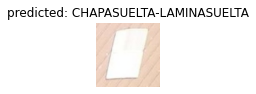

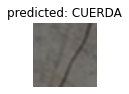

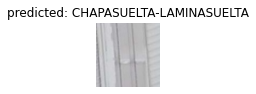

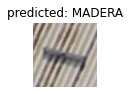

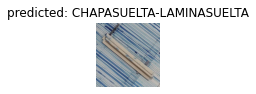

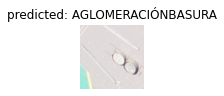

In [ ]:
visualize_model(model_vgg)

In [ ]:
matrix_vgg,real_vgg,predicted_vgg=matrix_conf(model_vgg,class_names)


Confusion matrix, without normalization


<Figure size 432x288 with 0 Axes>

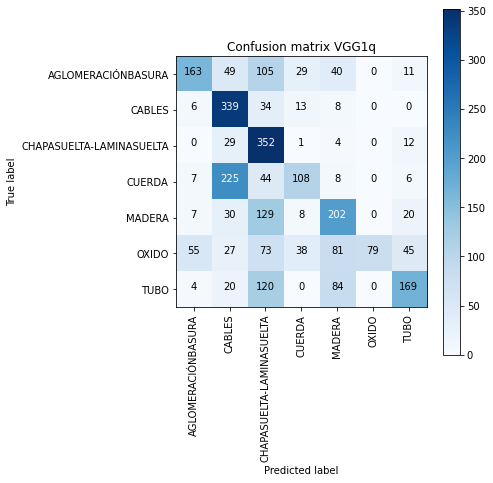

In [ ]:
plt.figure()
plot_confusion_matrix(matrix_vgg, classes=class_names,
                      title='Confusion matrix VGG1q')
plt.show()